In [1]:
import pickle
from dataclasses import dataclass

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [2]:
MOISTURE_NUM_STEPS = 16
AMMONIUM_NUM_STEPS = 10
NITRATE_NUM_STEPS = 25
PROBABILITY_OF_CLEAR_FORECAST = 0.405224

In [3]:
weights_for_pareto = np.zeros([2, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS], np.float64)
weights_for_pareto[:, 0, 0:2, 0:5] = 0.05
weights_for_pareto[:, 1, 0:2, 0:5] = 0.33
weights_for_pareto[:, 2, 0:2, 0:5] = 0.18
weights_for_pareto[:, 3, 0:2, 0:5] = 0.15
weights_for_pareto[:, 4, 0:2, 0:5] = 0.15
weights_for_pareto[:, 5, 0:2, 0:5] = 0.14
weights_for_pareto[0] *= PROBABILITY_OF_CLEAR_FORECAST
weights_for_pareto[1] *= (1 - PROBABILITY_OF_CLEAR_FORECAST)
weights_for_pareto /= np.sum(weights_for_pareto)

In [4]:
leaching_penalties_USD_per_m2 = np.linspace(0, 1.0734245700734262 / 2.0, 25)
leaching_penalties_USD_per_m2

array([0.        , 0.02236301, 0.04472602, 0.06708904, 0.08945205,
       0.11181506, 0.13417807, 0.15654108, 0.1789041 , 0.20126711,
       0.22363012, 0.24599313, 0.26835614, 0.29071915, 0.31308217,
       0.33544518, 0.35780819, 0.3801712 , 0.40253421, 0.42489723,
       0.44726024, 0.46962325, 0.49198626, 0.51434927, 0.53671229])

In [5]:
@dataclass
class ParetoOutcomes:
    expected_profit_by_initial_state: npt.NDArray[np.float64] # dimensions: fine, forecast, moisture, ammonium, nitrate
    probability_of_violation_by_initial_state: npt.NDArray[np.float64] # dimensions: fine, forecast, moisture, ammonium, nitrate
    average_profits: npt.NDArray[np.float64] # 1D, fine
    average_probability_of_violation: npt.NDArray[np.float64] #1D, fine
    average_pre_fine_profits: npt.NDArray[np.float64] # 1D, fine

    def __init__(self, expected_profit_by_initial_state, probability_of_violation_by_initial_state):
        self.expected_profit_by_initial_state = expected_profit_by_initial_state
        self.probability_of_violation_by_initial_state = probability_of_violation_by_initial_state
        self.average_profits = np.average(expected_profit_by_initial_state, axis=(1, 2, 3, 4), weights=weights_for_pareto)
        self.average_probability_of_violation = np.average(probability_of_violation_by_initial_state, axis=(1, 2, 3, 4), weights=weights_for_pareto)
        self.average_pre_fine_profits = self.average_profits + (self.average_probability_of_violation * leaching_penalties_USD_per_m2)

In [6]:
pareto_outcomes_by_num_control_steps = {}

In [7]:
with open("36_pareto_sweep_expected_profit.pickle", "rb") as f:
    single_application_pareto_expected_profits = pickle.load(f)
with open("36_pareto_sweep_probability_of_violation.pickle", "rb") as f:
    single_application_pareto_probability_of_violation = pickle.load(f)
pareto_outcomes_by_num_control_steps[1] = ParetoOutcomes(single_application_pareto_expected_profits, single_application_pareto_probability_of_violation)

In [8]:
with open("9_pareto_sweep_expected_profit.pickle", "rb") as f:
    x4_application_pareto_expected_profits = pickle.load(f)
with open("9_pareto_sweep_probability_of_violation.pickle", "rb") as f:
    x4_application_pareto_probability_of_violation = pickle.load(f)
pareto_outcomes_by_num_control_steps[4] = ParetoOutcomes(x4_application_pareto_expected_profits, x4_application_pareto_probability_of_violation)

In [9]:
with open("3_pareto_sweep_expected_profit.pickle", "rb") as f:
    max_application_pareto_expected_profits = pickle.load(f)
with open("3_pareto_sweep_probability_of_violation.pickle", "rb") as f:
    max_application_pareto_probability_of_violation = pickle.load(f)
pareto_outcomes_by_num_control_steps[12] = ParetoOutcomes(max_application_pareto_expected_profits, max_application_pareto_probability_of_violation)

In [10]:
pareto_outcomes_by_num_control_steps[12].average_probability_of_violation

array([0.59851396, 0.56487898, 0.5426472 , 0.53865761, 0.53646813,
       0.53532207, 0.53463429, 0.53407869, 0.5330542 , 0.53220343,
       0.53026118, 0.52943479, 0.52879043, 0.52471948, 0.52307561,
       0.52027602, 0.51872155, 0.51608057, 0.51465737, 0.50642605,
       0.50222721, 0.50113218, 0.49973731, 0.49873699, 0.49507102])

In [11]:
# with open("pareto_sweep_expected_profit.pickle", "rb") as f:
#     x4_application_pareto_expected_profits = pickle.load(f)
# with open("pareto_sweep_probability_of_violation.pickle", "rb") as f:
#     x4_application_pareto_probability_of_violation = pickle.load(f)
# pareto_outcomes_by_num_control_steps[4] = ParetoOutcomes(x4_application_pareto_expected_profits, x4_application_pareto_probability_of_violation)

In [12]:
CHOSEN_FINE_IDX = 9

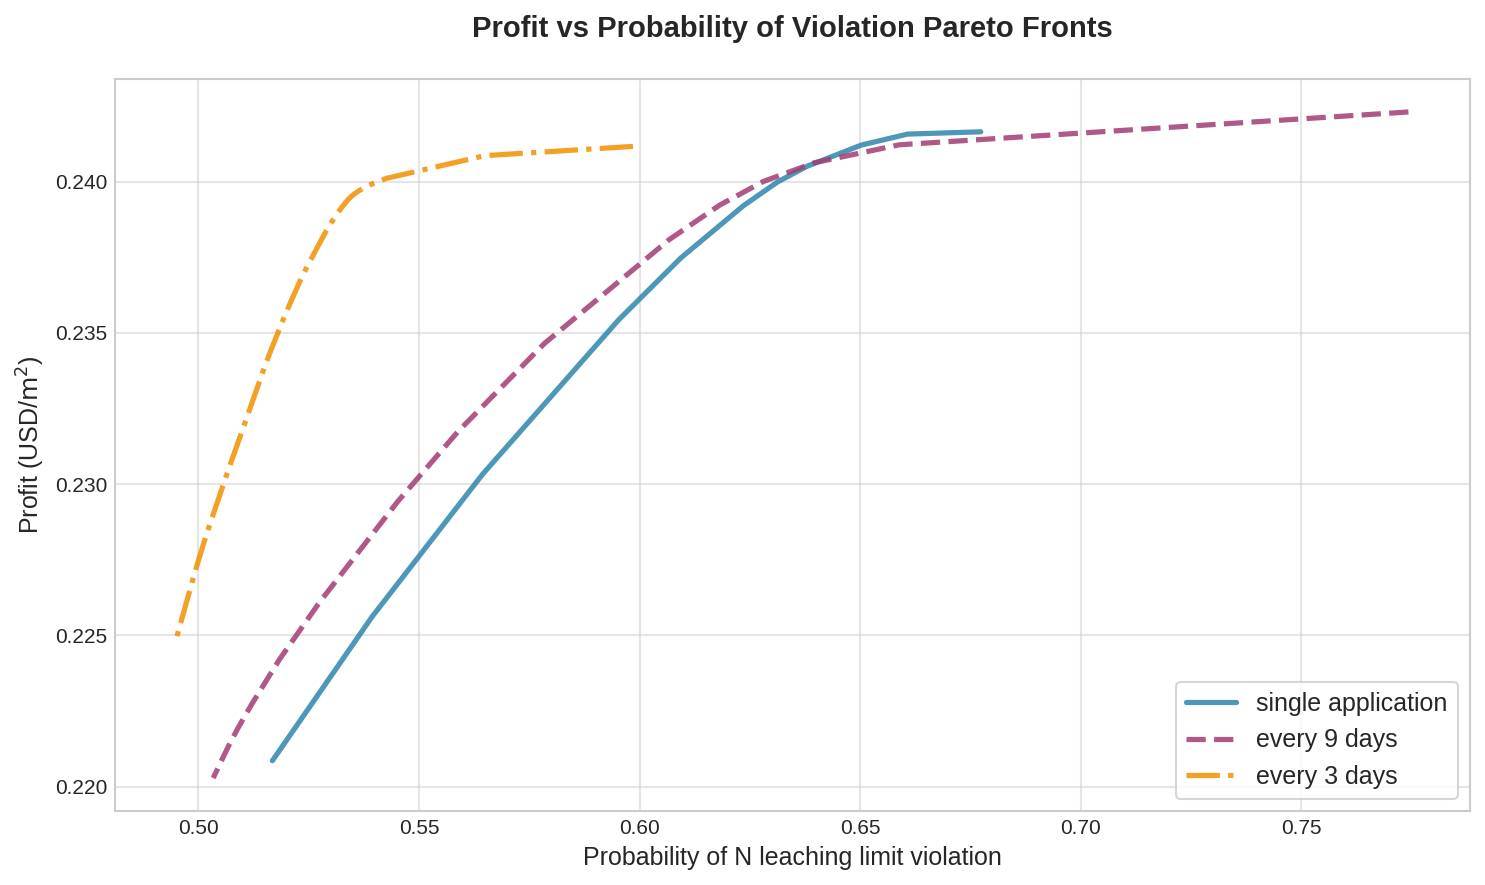

In [13]:
# Set a modern style
plt.style.use('seaborn-v0_8-whitegrid')  # or try 'seaborn-v0_8-whitegrid', 'bmh', 'ggplot'

# Define a modern color palette (works well in both color and grayscale)
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51']

# Define line styles to cycle through
line_styles = ['-', '--', '-.', ':']
markers_for_lines = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

for idx, (key, value) in enumerate(pareto_outcomes_by_num_control_steps.items()):
    label = "single application" if key == 1 else "every {:d} days".format(int(36 / key))
    ax.plot(value.average_probability_of_violation[value.average_pre_fine_profits > 0.22], 
            value.average_pre_fine_profits[value.average_pre_fine_profits > 0.22], 
            label=label,
            linestyle=line_styles[idx % len(line_styles)],
            linewidth=2.5,
            # marker=markers_for_lines[idx % len(markers_for_lines)],
            # markersize=6,
            # markevery=0.15,
            color=colors[idx % len(colors)],
            alpha=0.85)

# ax.scatter(pareto_outcomes_by_num_control_steps[12].average_probability_of_violation[CHOSEN_FINE_IDX],
#            pareto_outcomes_by_num_control_steps[12].average_pre_fine_profits[CHOSEN_FINE_IDX],
#            marker="*",
#            s=400,
#            color='#F4A259',
#            edgecolors='#2D3142',
#            linewidths=2,
#            zorder=5,
#            label='Chosen operating point')
#
# ax.scatter(pareto_outcomes_by_num_control_steps[1].average_probability_of_violation[0],
#            pareto_outcomes_by_num_control_steps[1].average_pre_fine_profits[0],
#            marker="s",
#            s=250,
#            color='#4ECDC4',
#            edgecolors='#2D3142',
#            linewidths=2,
#            zorder=5,
#            label='Reference point')

ax.set_title("Profit vs Probability of Violation Pareto Fronts", fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel("Profit (USD/$\\text{m}^2$)", fontsize=12)
ax.set_xlabel("Probability of N leaching limit violation", fontsize=12)
ax.legend(loc="lower right", frameon=True, shadow=False, fontsize=12)
ax.grid(True, alpha=0.5, lw=1.0)

plt.tight_layout()
plt.savefig("pareto_fronts.png", transparent=True, dpi=300, bbox_inches='tight')

In [14]:
for i in range(len(leaching_penalties_USD_per_m2) - 1):
    if (pareto_outcomes_by_num_control_steps[4].average_probability_of_violation[i] > pareto_outcomes_by_num_control_steps[4].average_probability_of_violation[i + 1]) and (pareto_outcomes_by_num_control_steps[4].average_pre_fine_profits[i] < pareto_outcomes_by_num_control_steps[4].average_pre_fine_profits[i + 1]):
        print("{} is better than {}, {:.2f}% vs {:.2f}% probability of violation and ${:.3f} vs ${:.3f} pre-fine profit".format(i + 1, i, pareto_outcomes_by_num_control_steps[4].average_probability_of_violation[i + 1] * 100.0, pareto_outcomes_by_num_control_steps[4].average_probability_of_violation[i] * 100.0, pareto_outcomes_by_num_control_steps[4].average_pre_fine_profits[i + 1], pareto_outcomes_by_num_control_steps[4].average_pre_fine_profits[i]))

In [15]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    for profit_idx, profit in enumerate(value.average_pre_fine_profits):
        if profit/max(value.average_pre_fine_profits) <= 0.95:
            print(profit_idx, leaching_penalties_USD_per_m2[profit_idx])
            break

9 0.20126710688876742
8 0.1789040950122377
20 0.44726023753059424


In [16]:
leaching_penalties_USD_per_m2[CHOSEN_FINE_IDX]

np.float64(0.20126710688876742)

In [17]:
pareto_outcomes_by_num_control_steps[1].average_probability_of_violation[0]

np.float64(0.677353968)

In [18]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    print("x{} optimal operating leaching violation: {:.2f}, profit: {:.3f}".format(key, value.average_probability_of_violation[CHOSEN_FINE_IDX], value.average_pre_fine_profits[CHOSEN_FINE_IDX]))
    print("\t as percent of max: {:.2f}, profit: {:.3f}".format(value.average_probability_of_violation[CHOSEN_FINE_IDX] / pareto_outcomes_by_num_control_steps[1].average_probability_of_violation[0], value.average_pre_fine_profits[CHOSEN_FINE_IDX] / pareto_outcomes_by_num_control_steps[1].average_profits[0]))

x1 optimal operating leaching violation: 0.54, profit: 0.226
	 as percent of max: 0.80, profit: 0.934
x4 optimal operating leaching violation: 0.53, profit: 0.226
	 as percent of max: 0.78, profit: 0.936
x12 optimal operating leaching violation: 0.53, profit: 0.239
	 as percent of max: 0.79, profit: 0.989


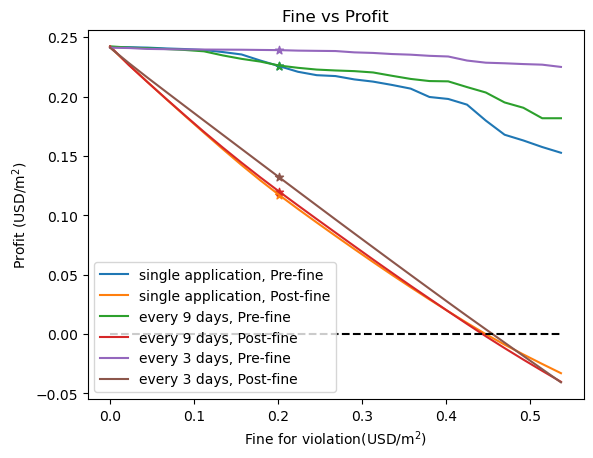

In [19]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    label = "single application" if key == 1 else "every {:d} days".format(int(36 / key))
    plt.plot(leaching_penalties_USD_per_m2, value.average_pre_fine_profits, label=label + ", Pre-fine")
    plt.scatter(leaching_penalties_USD_per_m2[CHOSEN_FINE_IDX], value.average_pre_fine_profits[CHOSEN_FINE_IDX], marker="*")
    plt.plot(leaching_penalties_USD_per_m2, value.average_profits, label=label + ", Post-fine")
    plt.scatter(leaching_penalties_USD_per_m2[CHOSEN_FINE_IDX], value.average_profits[CHOSEN_FINE_IDX], marker="*")
plt.title("Fine vs Profit")
plt.ylabel("Profit (USD/$\\text{m}^2$)")
plt.xlabel("Fine for violation(USD/$\\text{m}^2$)")
plt.hlines([0.0], xmin=0.0, xmax=max(leaching_penalties_USD_per_m2), color="black", linestyles="dashed")
plt.legend(loc="lower left")

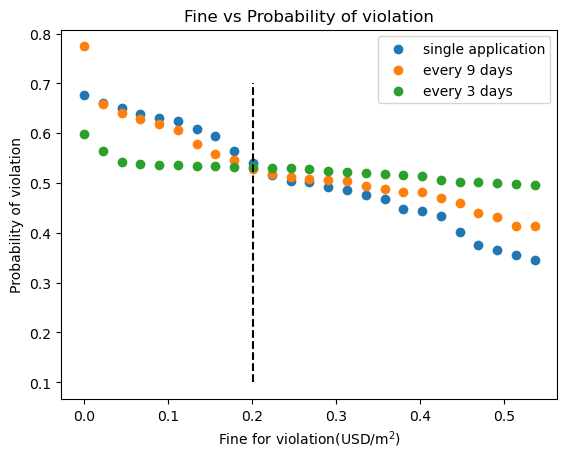

In [20]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    label = "single application" if key == 1 else "every {:d} days".format(int(36 / key))
    plt.scatter(leaching_penalties_USD_per_m2, value.average_probability_of_violation, label=label)
plt.vlines([leaching_penalties_USD_per_m2[CHOSEN_FINE_IDX]], ymin=0.1, ymax=0.7, color="black", linestyle="dashed")
plt.title("Fine vs Probability of violation")
plt.ylabel("Probability of violation")
plt.xlabel("Fine for violation(USD/$\\text{m}^2$)")
plt.legend(loc="upper right")

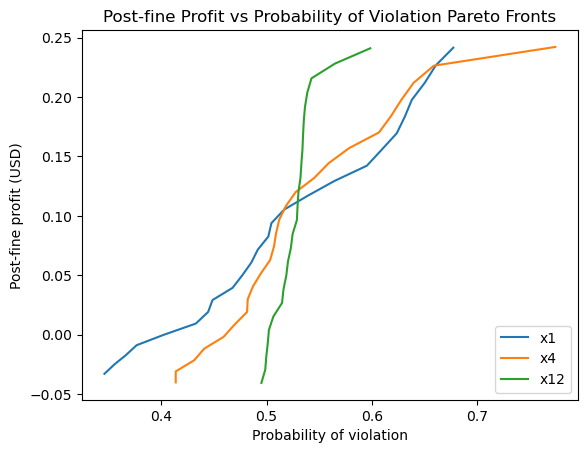

In [21]:
for key, value in pareto_outcomes_by_num_control_steps.items():
    plt.plot(value.average_probability_of_violation, value.average_profits, label="x" + str(key))
plt.title("Post-fine Profit vs Probability of Violation Pareto Fronts")
plt.ylabel("Post-fine profit (USD)")
plt.xlabel("Probability of violation")
plt.legend(loc="lower right")

In [22]:
print("Maximum profit without leaching concerns")
for key, value in pareto_outcomes_by_num_control_steps.items():
    print("x{}: \t{}".format(key, value.average_profits[0]))

Maximum profit without leaching concerns
x1: 	0.2416460952302434
x4: 	0.24230131059410526
x12: 	0.24116366333499414
